In [115]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [116]:
DATAROOT = "WIT-UAV-Dataset"
os.listdir(DATAROOT)

['2022-05-11_FIRE-SGL-111-Confluence_M600',
 '2022-11-08_FIRE-SGL-108-Reade-Township_M600',
 '2021-11-08_FIRE-SGL-174-Rossiter_M100']

- seek cameras
- FLIR cameras


per folder: 
- how many total boxes per class?
- what percentage of detections to no detections?
- visualization of detection number over time?
- size statistics of boxes?
- height of UAS?

how to ensure similar distributions of fire vs no fire?

```
WIT-UAV-Dataset
├── 2021-11-08_FIRE-SGL-174-Rossiter_M100-Data-Collect
│   ├── 2021-11-07_19-19-31_dji_sdk_and_thermal.repaired
│   ├── 2021-11-07_19-19-36_dji_sdk_and_thermal.repaired
│   ├── 2021-11-07_19-19-54_dji_sdk_and_thermal
│   └── 2021-11-07_19-20-26_dji_sdk_and_thermal.repaired
├── 2022-05-11_FIRE-SGL-111-Confluence_M600-Data-Collect
│   ├── seek_displayImage
│   │   ├── 2022-04-27_00-18-06
│   │   ├── 2022-04-27_00-18-47
│   │   └── 2022-04-27_00-24-53
│   └── thermal_1_image_rect
│       ├── 2022-04-27_00-18-06
│       ├── 2022-04-27_00-18-47
│       └── 2022-04-27_00-24-53
└── 2022-11-08_FIRE-SGL-108-Reade-Township_M600-Coverage-Test
    ├── 2022-11-08_13-15-55_dji_sdk_and_thermal
    ├── 2022-11-08_14-13-12_dji_sdk_and_thermal
    └── 2022-11-08_14-40-21_dji_sdk_and_thermal.kinda-repaired-images-only_labeled
```

In [117]:
list_of_runs = []
for dirpath, dirnames, filenames in os.walk(DATAROOT):
    if not dirnames:
        list_of_runs.append(dirpath)
        print(dirpath, "has 0 subdirectories and", len(filenames), "files")
list_of_runs = sorted(list_of_runs)

WIT-UAV-Dataset/2022-05-11_FIRE-SGL-111-Confluence_M600/2022-04-27_00-24-53_seek has 0 subdirectories and 1303 files
WIT-UAV-Dataset/2022-05-11_FIRE-SGL-111-Confluence_M600/2022-04-27_00-18-06_flir has 0 subdirectories and 1177 files
WIT-UAV-Dataset/2022-05-11_FIRE-SGL-111-Confluence_M600/2022-04-27_00-18-47_flir has 0 subdirectories and 1227 files
WIT-UAV-Dataset/2022-05-11_FIRE-SGL-111-Confluence_M600/2022-04-27_00-18-47_seek has 0 subdirectories and 2182 files
WIT-UAV-Dataset/2022-05-11_FIRE-SGL-111-Confluence_M600/2022-04-27_00-18-06_seek has 0 subdirectories and 1585 files
WIT-UAV-Dataset/2022-05-11_FIRE-SGL-111-Confluence_M600/2022-04-27_00-24-53_flir has 0 subdirectories and 1184 files
WIT-UAV-Dataset/2022-11-08_FIRE-SGL-108-Reade-Township_M600/2022-11-08_13-15-55_seek has 0 subdirectories and 250 files
WIT-UAV-Dataset/2022-11-08_FIRE-SGL-108-Reade-Township_M600/2022-11-08_14-13-12_seek has 0 subdirectories and 193 files
WIT-UAV-Dataset/2022-11-08_FIRE-SGL-108-Reade-Township_M60

In [118]:
list_of_runs

['WIT-UAV-Dataset/2021-11-08_FIRE-SGL-174-Rossiter_M100/2021-11-07_19-19-31_flir',
 'WIT-UAV-Dataset/2021-11-08_FIRE-SGL-174-Rossiter_M100/2021-11-07_19-19-36_flir',
 'WIT-UAV-Dataset/2021-11-08_FIRE-SGL-174-Rossiter_M100/2021-11-07_19-19-54_flir',
 'WIT-UAV-Dataset/2021-11-08_FIRE-SGL-174-Rossiter_M100/2021-11-07_19-20-26_flir',
 'WIT-UAV-Dataset/2022-05-11_FIRE-SGL-111-Confluence_M600/2022-04-27_00-18-06_flir',
 'WIT-UAV-Dataset/2022-05-11_FIRE-SGL-111-Confluence_M600/2022-04-27_00-18-06_seek',
 'WIT-UAV-Dataset/2022-05-11_FIRE-SGL-111-Confluence_M600/2022-04-27_00-18-47_flir',
 'WIT-UAV-Dataset/2022-05-11_FIRE-SGL-111-Confluence_M600/2022-04-27_00-18-47_seek',
 'WIT-UAV-Dataset/2022-05-11_FIRE-SGL-111-Confluence_M600/2022-04-27_00-24-53_flir',
 'WIT-UAV-Dataset/2022-05-11_FIRE-SGL-111-Confluence_M600/2022-04-27_00-24-53_seek',
 'WIT-UAV-Dataset/2022-11-08_FIRE-SGL-108-Reade-Township_M600/2022-11-08_13-15-55_seek',
 'WIT-UAV-Dataset/2022-11-08_FIRE-SGL-108-Reade-Township_M600/2022-11

In [119]:
run = list_of_runs[1]

In [120]:
run

'WIT-UAV-Dataset/2021-11-08_FIRE-SGL-174-Rossiter_M100/2021-11-07_19-19-36_flir'

In [121]:
def count_detections_per_class(path):
    num_v = 0
    num_h = 0
    with open(path, "r") as f:
        lines = f.readlines()
        # if len(lines) == 0:
        #     print(lines)
        #     raise ValueError(f"File {path} is empty")
        for line in lines:
            if "v" in line or "c" in line:
                num_v += 1
            elif "h" in line:
                num_h += 1
            else:
                print(lines)
                raise ValueError(f"File {path} has no class")
    return num_v, num_h

In [122]:
def count_run_stats(run):
    num_total = 0
    num_labeled = 0
    total_num_v = 0
    total_num_h = 0
    width, height = 0, 0
    sgl = None
    if "Rossiter" in run:
        sgl = "Rossiter"
    elif "Confluence" in run:
        sgl = "Confluence"
    elif "Reade-Township" in run:
        sgl = "Reade"
    else:
        sgl = "Unknown"

    for f in os.listdir(run):
        if "label" in f: # is label file
            num_v, num_h = count_detections_per_class(run + "/" + f)
            total_num_v += num_v
            total_num_h += num_h

            if num_v > 0 or num_h > 0:
                num_labeled += 1
        else: # is image file
            if width == 0: # if resolution is not set, then set it
                # find resolution from image file
                img = cv2.imread(run + "/" + f)
                height, width, _ = img.shape
            num_total += 1
    
    # print(f"resolution={width}, {height}")
    # print(f"{num_total=}, {num_labeled=}, {total_num_v=}, {total_num_h=}")
    # print(f"percentage labeled={num_labeled/num_total}")
    return sgl, num_total, num_labeled, total_num_v, total_num_h, width, height

In [165]:
rename_dict = {}
# pandas dataframe to store information about each run
df = pd.DataFrame(columns=["folder", "num_total", "num_labeled", "total_num_v", "total_num_h", "resolution"])
rossiter_idx = 0
confluence_idx = 0
reade_idx = 0
for run in list_of_runs:
    sgl, num_total, num_labeled, total_num_v, total_num_h, width, height = count_run_stats(run)
    if sgl == "Rossiter":
        rossiter_idx += 1
        run_idx = rossiter_idx
    elif sgl == "Confluence":
        confluence_idx += 1
        run_idx = confluence_idx
    elif sgl == "Reade":
        reade_idx += 1
        run_idx = reade_idx
    else:
        pass
    
    # find type of camera from folder name
    cam = run.split("_")[-1] 
    run_name = f"{sgl}_{run_idx}_{cam}"
    
    # folder name is the run name minus the path
    folder = run.split("/")[-1]

    # store folder : run_name in dictionary 
    # to be used to rename folders later
    rename_dict[folder] = run_name

    df = pd.concat([df, pd.DataFrame({"folder": run_name, "sgl": sgl, "num_total": num_total, "num_labeled": num_labeled, "total_num_v": total_num_v, "total_num_h": total_num_h, "resolution": f"{width}x{height}"}, index=[0])], ignore_index=True)
print(rename_dict)
df.head()

{'2021-11-07_19-19-31_flir': 'Rossiter_1_flir', '2021-11-07_19-19-36_flir': 'Rossiter_2_flir', '2021-11-07_19-19-54_flir': 'Rossiter_3_flir', '2021-11-07_19-20-26_flir': 'Rossiter_4_flir', '2022-04-27_00-18-06_flir': 'Confluence_1_flir', '2022-04-27_00-18-06_seek': 'Confluence_2_seek', '2022-04-27_00-18-47_flir': 'Confluence_3_flir', '2022-04-27_00-18-47_seek': 'Confluence_4_seek', '2022-04-27_00-24-53_flir': 'Confluence_5_flir', '2022-04-27_00-24-53_seek': 'Confluence_6_seek', '2022-11-08_13-15-55_seek': 'Reade_1_seek', '2022-11-08_14-13-12_seek': 'Reade_2_seek', '2022-11-08_14-40-21_seek': 'Reade_3_seek'}


,folder,num_total,num_labeled,total_num_v,total_num_h,resolution,sgl
0,Rossiter_1_flir,368,47,36,176,640x512,Rossiter
1,Rossiter_2_flir,469,46,101,59,640x512,Rossiter
2,Rossiter_3_flir,49,22,0,33,640x512,Rossiter
3,Rossiter_4_flir,150,54,0,137,640x512,Rossiter
4,Confluence_1_flir,974,49,50,0,640x512,Confluence


Total percent labelled: 29.645063945969248 %
Total number of images: 6959


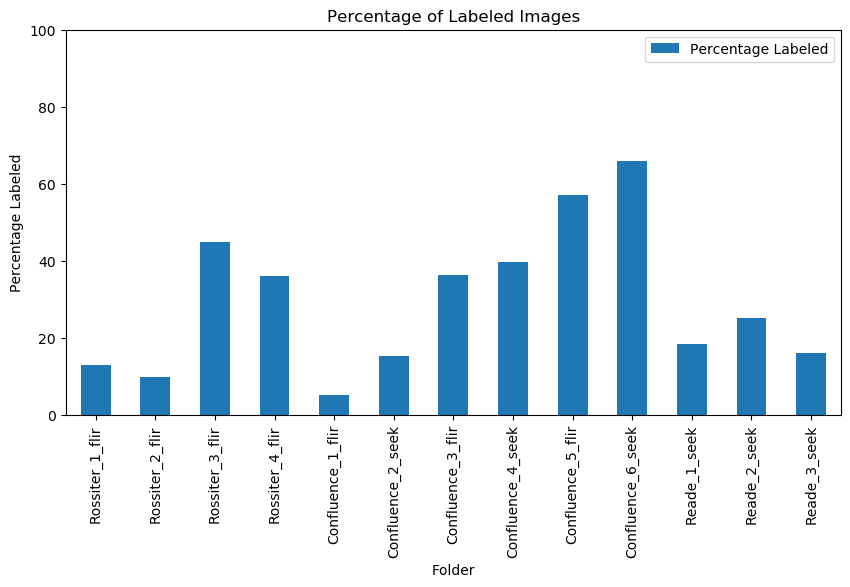

In [160]:
# find percentage of labeled images
df["percentage_labeled"] = df["num_labeled"] / df["num_total"] * 100
# find total percentage of labeled images
total_labeled = df["num_labeled"].sum() / df["num_total"].sum()
print(f"Total percent labelled: {total_labeled * 100} %")
# plot percentage of labeled images vs folder. y scale is 0 to 100
df.plot(x="folder", y="percentage_labeled", kind="bar", figsize=(10, 5), ylim=(0, 100), title="Percentage of Labeled Images", ylabel="Percentage Labeled", xlabel="Folder")
plt.legend(["Percentage Labeled"])
df.head()

# Find total number of images
total_images = df["num_total"].sum()
print(f"Total number of images: {total_images}")

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 <a list of 13 Text xticklabel objects>)

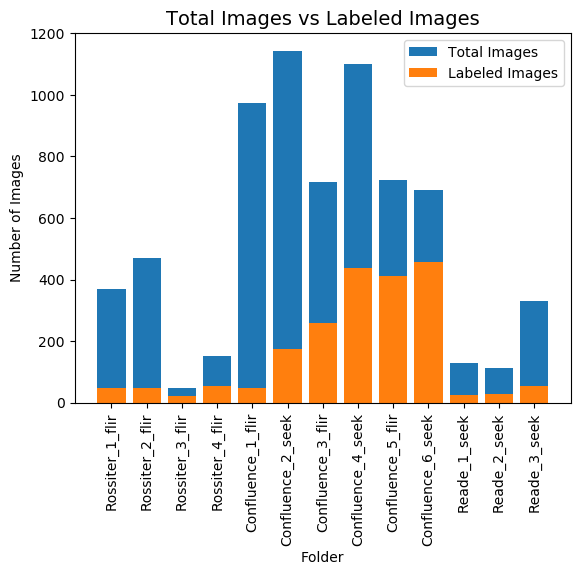

In [167]:
# plot total number of images and total number of labeled images stacked in a bar chart vs folder
plt.bar(df["folder"], df["num_total"], label="Total Images")
plt.bar(df["folder"], df["num_labeled"], label="Labeled Images")
plt.legend()
plt.title("Total Images vs Labeled Images", fontsize=14)
plt.xlabel("Folder")
plt.ylabel("Number of Images")

# # add percentage of labeled images as text on top of 2nd bar, make the text white, small font size, and centered, rotated by 90 degrees
# for i in range(len(df)):
#     plt.text(i, df["num_labeled"][i], f"{df['percentage_labeled'][i]:.2f}%", color="white", fontsize=8, ha="center", va="bottom", rotation=90)
# fix x labels overlapping by rotating them
plt.xticks(rotation=90)


Total number of vehicles: 5030
Total number of humans: 1543


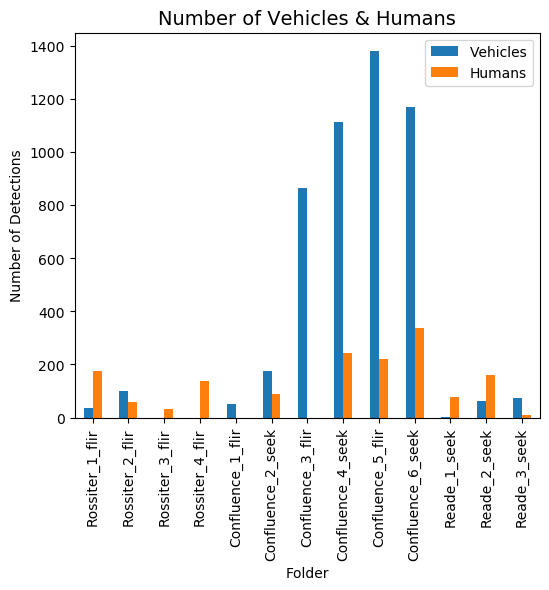

In [169]:
# plot number of vehicles and humans vs folder
# legend is number of vehicles and humans
df.plot(x="folder", y=["total_num_v", "total_num_h"], kind="bar", figsize=(6, 5), title="Number of Vehicles & Humans" , ylabel="Number of Detections", xlabel="Folder", legend=True)
# set title font size to 14
plt.title("Number of Vehicles & Humans", fontsize=14)
plt.legend(["Vehicles", "Humans"])
# add values of total number of vehicles and humans on top of bars
# for i, row in df.iterrows():
#     plt.text(i - 0.3, row["total_num_v"] + 10, row["total_num_v"])
#     plt.text(i + 0.0, row["total_num_h"] + 10, row["total_num_h"])

# find total number of vehicles and humans
total_num_v = df["total_num_v"].sum()
total_num_h = df["total_num_h"].sum()
print(f"Total number of vehicles: {total_num_v}")
print(f"Total number of humans: {total_num_h}")


Total number of 320x240 images: 3510
Total number of 640x512 images: 3449
Total number of 320x240 labeled images: 1172
Total number of 640x512 labeled images: 891


<BarContainer object of 2 artists>

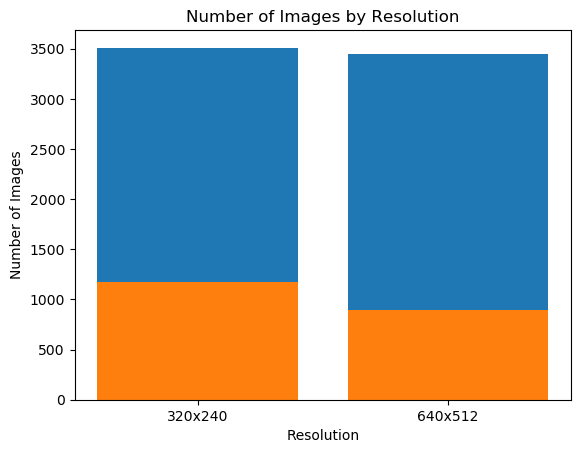

In [163]:
# find total number of 320x240 images
total_320x240 = df[df["resolution"] == "320x240"]["num_total"].sum()

# find total number of 640x512 images
total_640x512 = df[df["resolution"] == "640x512"]["num_total"].sum()

print(f"Total number of 320x240 images: {total_320x240}")
print(f"Total number of 640x512 images: {total_640x512}")

# plot number of 320x240 and 640x512 images calculated above with x,y labels and title
plt.bar(["320x240", "640x512"], [total_320x240, total_640x512])
plt.title("Number of Images by Resolution")
plt.xlabel("Resolution")
plt.ylabel("Number of Images")

# find total number of 320x240 labeled images
total_320x240_labeled = df[df["resolution"] == "320x240"]["num_labeled"].sum()

# find total number of 640x512 labeled images
total_640x512_labeled = df[df["resolution"] == "640x512"]["num_labeled"].sum()

print(f"Total number of 320x240 labeled images: {total_320x240_labeled}")
print(f"Total number of 640x512 labeled images: {total_640x512_labeled}")

# plot number of 320x240 and 640x512 labeled images calculated above with x,y labels and title
plt.bar(["320x240", "640x512"], [total_320x240_labeled, total_640x512_labeled])



# Train/Val/Test Split

70 15 15

10 files
7 train
1 val
2 test (flip these

In [128]:
print(DATAROOT)

WIT-UAV-Dataset


In [129]:
from glob import glob
glob(DATAROOT+"/**/.png", recursive=True)

[]

In [130]:
train_files = []
val_files = []
test_files = []

import random
from itertools import zip_longest

def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def swap(a, b):
    return b, a

for run in list_of_runs:
    print("------")
    print(run)
    
    files_of_10 = chunker([run + "/" + fi for fi in os.listdir(run) if fi.endswith(".png")], 10)
    
    num_val = 2
    
    
    for ten_files in files_of_10:
        shuffled = list(ten_files)
        random.shuffle(shuffled)
        trains = shuffled[:7]
        vals = shuffled[7:7+num_val]
        tests = shuffled[7+num_val:]
        
        train_files += trains
        val_files += vals
        test_files += tests
        num_val = 3 - num_val

------
WIT-UAV-Dataset/2021-11-08_FIRE-SGL-174-Rossiter_M100/2021-11-07_19-19-31_flir
------
WIT-UAV-Dataset/2021-11-08_FIRE-SGL-174-Rossiter_M100/2021-11-07_19-19-36_flir
------
WIT-UAV-Dataset/2021-11-08_FIRE-SGL-174-Rossiter_M100/2021-11-07_19-19-54_flir
------
WIT-UAV-Dataset/2021-11-08_FIRE-SGL-174-Rossiter_M100/2021-11-07_19-20-26_flir
------
WIT-UAV-Dataset/2022-05-11_FIRE-SGL-111-Confluence_M600/2022-04-27_00-18-06_flir
------
WIT-UAV-Dataset/2022-05-11_FIRE-SGL-111-Confluence_M600/2022-04-27_00-18-06_seek
------
WIT-UAV-Dataset/2022-05-11_FIRE-SGL-111-Confluence_M600/2022-04-27_00-18-47_flir
------
WIT-UAV-Dataset/2022-05-11_FIRE-SGL-111-Confluence_M600/2022-04-27_00-18-47_seek
------
WIT-UAV-Dataset/2022-05-11_FIRE-SGL-111-Confluence_M600/2022-04-27_00-24-53_flir
------
WIT-UAV-Dataset/2022-05-11_FIRE-SGL-111-Confluence_M600/2022-04-27_00-24-53_seek
------
WIT-UAV-Dataset/2022-11-08_FIRE-SGL-108-Reade-Township_M600/2022-11-08_13-15-55_seek
------
WIT-UAV-Dataset/2022-11-08_FI

In [131]:
len(train_files), len(val_files), len(test_files)

(4877, 1043, 1031)

In [132]:

test_files += val_files[-6:]
val_files = val_files[:-6]

In [133]:
len(val_files), len(test_files)

(1037, 1037)

In [134]:
import shutil

def copy_out(files, output_path):
    
    for t in files:
        t_no_parent_folder = t[len(DATAROOT):]
        target_file = f"{output_path}/" + t_no_parent_folder
        print("copy", t, "to", target_file)
        os.makedirs(os.path.dirname(target_file), exist_ok=True)
        shutil.copyfile(t, target_file)

        label_file = t[:-4]  + ".label"
        if os.path.isfile(label_file):
            target_file = f"{output_path}/" + label_file[len(DATAROOT):]
            print("copy", label_file, "to", target_file)
            os.makedirs(os.path.dirname(target_file), exist_ok=True)
            shutil.copyfile(label_file, target_file)

In [135]:
# copy_out(train_files, "train")
# copy_out(val_files, "val")
# copy_out(test_files, "test")